In [1]:
import os
import pickle
import timeit
from datetime import datetime, timedelta
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
nlct_dir_path = "/mnt/data2/jturner/nlct_data/georges_bank/"

In [3]:
nlct_dates = sorted(os.listdir(nlct_dir_path))

#--- Removing any non-date directory items
#--- Currently only including 2023
nlct_dates = [x for x in nlct_dates if x[:4] == '2023']
nlct_dates

['20230101',
 '20230102',
 '20230103',
 '20230104',
 '20230105',
 '20230106',
 '20230107',
 '20230108',
 '20230109',
 '20230110',
 '20230111',
 '20230112',
 '20230113',
 '20230114',
 '20230115',
 '20230116',
 '20230117',
 '20230118',
 '20230119',
 '20230120',
 '20230121',
 '20230122',
 '20230123',
 '20230124',
 '20230125',
 '20230126',
 '20230127',
 '20230128',
 '20230129',
 '20230130',
 '20230131',
 '20230201',
 '20230202',
 '20230203',
 '20230204',
 '20230205',
 '20230206',
 '20230207',
 '20230208',
 '20230209',
 '20230210',
 '20230211',
 '20230212',
 '20230213',
 '20230214',
 '20230215',
 '20230216',
 '20230217',
 '20230218',
 '20230219',
 '20230220',
 '20230221',
 '20230222',
 '20230223',
 '20230224',
 '20230225',
 '20230226',
 '20230227',
 '20230228',
 '20230301',
 '20230302',
 '20230303',
 '20230304',
 '20230305',
 '20230306',
 '20230307',
 '20230308',
 '20230309',
 '20230310',
 '20230311',
 '20230312',
 '20230313',
 '20230314',
 '20230315',
 '20230316',
 '20230317',
 '20230318',

Creating the static feature function: 

In [4]:
def get_static_features(BTD_c, nlct_dir_path, nlct_date):
    #--- Initialize an array of 1's in the shape of the final image
    BTD_prod = [ [1]*len(BTD_c[0][0]) for i in range(len(BTD_c[0]))]

    #--- Starting the timer
    starttime = timeit.default_timer()

    #--- Include all times or just top of hour (TOH)
    all_files = sorted(os.listdir(nlct_dir_path+nlct_date+'/'))
    toh_files = [filename for filename in all_files if filename.endswith('00M')]

    for filename in toh_files:

            #--- Open the NLCT file
            file = open(nlct_dir_path+nlct_date+'/'+filename, 'rb')
            BTD = pickle.load(file)
            file.close()

            #--- Crop to the specified region
            BTD = BTD.where((BTD.lat>min_lat) & (BTD.lat<max_lat) & (BTD.lon>min_lon) & (BTD.lon<max_lon))
            BTD = BTD.dropna(dim="y", how="all")
            BTD = BTD.dropna(dim="x", how="all")

            #--- Set negative values to zero
            BTD = np.where(BTD < 0, 0, BTD)

            #--- V1: Multiply to only enhance static clouds
            #BTD_prod = BTD_prod*BTD

            #--- V1: Limit runaway large values to 3
            #BTD_prod = np.where(BTD_prod > 3, 3, BTD_prod)
            
            #--- Mitigating error where BTD is not loaded
            if np.shape(BTD) != (1, 144, 156):
                print('BTD: ', np.shape(BTD), 'BTD_prod: ', np.shape(BTD_prod))
                BTD = [ [0]*len(BTD_c[0][0]) for i in range(len(BTD_c[0]))]
                
            #--- V2: Sum to enhance static clouds
            #print('BTD: ', np.shape(BTD), 'BTD_prod: ', np.shape(BTD_prod))
            BTD_prod = np.array(BTD_prod)+np.array(BTD)
            
            #print(filename)


    #print("Completed: ", timeit.default_timer() - starttime)

    return BTD_prod

Creating the static value function: 
* currently calculates each day twice, can make more efficient

In [5]:
def get_static_values(BTD_c, nlct_dir_path, nlct_date):
    
    BTD_prod = get_static_features(BTD_c, nlct_dir_path, nlct_date)
    
    #--- Create date variable
    date = datetime.strptime(nlct_date, "%Y%m%d")
    
    #--- Get the next day in sequence
    date2 = date + timedelta(days=1)
    nlct_date2 = date2.strftime("%Y%m%d")

    #--- Run static features for the next day
    BTD_prod2 = get_static_features(BTD_c, nlct_dir_path, nlct_date2)
    
    #--- Combine current day and next day static features
    BTD_tot = BTD_prod + BTD_prod2
    
    #--- V2: Limit to top 25%
    BTD_tot_lim = np.nan_to_num(BTD_tot, nan=0)
    BTD_tot_lim = BTD_tot_lim/np.max(BTD_tot_lim)
    limit = 0.75
    BTD_tot_lim = np.where(BTD_tot_lim < limit, 0, BTD_tot_lim)
    BTD_tot_lim = np.where(BTD_tot_lim > limit, 1, BTD_tot_lim)

    #--- Convert BTD prod (2d array) to value
    static_value = np.nansum(BTD_tot_lim)
    
    return date, static_value

Create sample to use as framework for loop:

In [6]:
sample_date = '20230101'
sample_nlct_path = nlct_dir_path+sample_date+"/"
sample_filename = 'goes_e_ntlc_'+sample_date[0:4]+'_'+sample_date[4:6]+'_'+sample_date[6:8]+'_00H_00M'

file = open(sample_nlct_path+sample_filename, 'rb')
BTD = pickle.load(file)
file.close()

#---Georges Bank
min_lon = -70.5
min_lat = 39
max_lon = -67
max_lat = 43

BTD_c = BTD.where((BTD.lat>min_lat) & (BTD.lat<max_lat) & (BTD.lon>min_lon) & (BTD.lon<max_lon))
BTD_c = BTD_c.dropna(dim="y", how="all")
BTD_c = BTD_c.dropna(dim="x", how="all")

Running the static value function for each date in NLCT directory: 

In [7]:
data = {'Date': [], 'StaticValue': []}
df = pd.DataFrame(data)

In [8]:
for nlct_date in tqdm(nlct_dates[:-1], desc="Processing", ncols=100):
    date, static_value = get_static_values(BTD_c, nlct_dir_path, nlct_date)
    #print(date, static_value)
    
    data_to_add = {
        'Date': date,
        'StaticValue': static_value
    }
    df = df.append(data_to_add, ignore_index=True)

Processing:  31%|███████████████▎                                  | 97/318 [00:25<01:03,  3.49it/s]

BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)
BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)


Processing:  31%|███████████████▍                                  | 98/318 [00:26<01:10,  3.12it/s]

BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)
BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)


Processing:  31%|███████████████▌                                  | 99/318 [00:26<01:15,  2.89it/s]

BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)
BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)


Processing:  31%|███████████████▍                                 | 100/318 [00:27<01:19,  2.76it/s]

BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)
BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)


Processing:  32%|███████████████▌                                 | 101/318 [00:27<01:21,  2.67it/s]

BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)
BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)


Processing:  32%|███████████████▋                                 | 102/318 [00:27<01:22,  2.62it/s]

BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)
BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)


Processing:  32%|███████████████▊                                 | 103/318 [00:28<01:23,  2.58it/s]

BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)
BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)


Processing:  33%|████████████████                                 | 104/318 [00:28<01:23,  2.56it/s]

BTD:  (1, 116, 153) BTD_prod:  (1, 144, 156)
BTD:  (1, 116, 153) BTD_prod:  (1, 144, 156)


Processing:  33%|████████████████▏                                | 105/318 [00:29<01:23,  2.54it/s]

BTD:  (1, 116, 153) BTD_prod:  (1, 144, 156)
BTD:  (1, 116, 153) BTD_prod:  (1, 144, 156)


Processing:  65%|███████████████████████████████▋                 | 206/318 [00:56<00:32,  3.46it/s]

BTD:  (1, 0, 0) BTD_prod:  (144, 156)
BTD:  (1, 0, 0) BTD_prod:  (144, 156)


Processing:  74%|████████████████████████████████████             | 234/318 [01:03<00:24,  3.46it/s]

BTD:  (1, 19, 137) BTD_prod:  (1, 144, 156)
BTD:  (1, 19, 137) BTD_prod:  (1, 144, 156)


Processing:  75%|████████████████████████████████████▊            | 239/318 [01:05<00:23,  3.37it/s]

BTD:  (1, 129, 154) BTD_prod:  (1, 144, 156)
BTD:  (1, 129, 154) BTD_prod:  (1, 144, 156)


Processing:  75%|████████████████████████████████████▉            | 240/318 [01:05<00:25,  3.05it/s]

BTD:  (1, 129, 154) BTD_prod:  (1, 144, 156)
BTD:  (1, 129, 154) BTD_prod:  (1, 144, 156)


Processing:  76%|█████████████████████████████████████▏           | 241/318 [01:05<00:27,  2.85it/s]

BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)
BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)
BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)


Processing:  76%|█████████████████████████████████████▎           | 242/318 [01:06<00:28,  2.71it/s]

BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)
BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)


Processing:  76%|█████████████████████████████████████▍           | 243/318 [01:06<00:28,  2.62it/s]

BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)
BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)


Processing:  77%|█████████████████████████████████████▌           | 244/318 [01:07<00:28,  2.55it/s]

BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)
BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)


Processing:  77%|█████████████████████████████████████▊           | 245/318 [01:07<00:29,  2.51it/s]

BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)
BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)


Processing:  77%|█████████████████████████████████████▉           | 246/318 [01:08<00:28,  2.48it/s]

BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)
BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)


Processing:  78%|██████████████████████████████████████           | 247/318 [01:08<00:28,  2.46it/s]

BTD:  (1, 0, 0) BTD_prod:  (1, 144, 156)


Processing: 100%|█████████████████████████████████████████████████| 318/318 [01:27<00:00,  3.63it/s]


In [9]:
df

,Date,StaticValue
0,2023-01-01,32.0
1,2023-01-02,724.0
2,2023-01-03,63.0
3,2023-01-04,46.0
4,2023-01-05,683.0
...,...,...
313,2023-11-10,273.0
314,2023-11-11,337.0
315,2023-11-12,4346.0
316,2023-11-13,1960.0


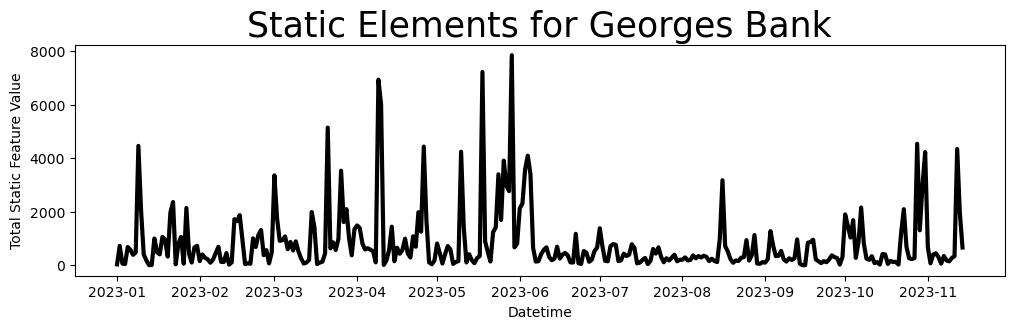

In [10]:
fig,ax=plt.subplots(1, figsize=(12,3))
ax.set_ylabel("Total Static Feature Value", fontsize=10)
ax.set_xlabel("Datetime", fontsize=10)
ax.set_title("Static Elements for Georges Bank", fontsize=25)

ax.plot(df.Date, df.StaticValue, c='black', linewidth=3)